In [1]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 

In [15]:
#importing the necessary libraries
import sys
import cv2
import torch
import torchvision
import numpy as np 
import pandas as pd
from torch import nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
df = pd.read_csv('/content/drive/MyDrive/DeepLearning_Dataset/Train.csv')

In [27]:
def mask_to_class_rgb(mask):
    color_dict={
    0: (0, 0, 0),  # Background
    1: (250,250,55),  # Class 1 represents Person
    2: (255,0,124),   # Class 2 represents Furniture
    3: (50,183,250),  # Class 3 represents Building
    4: (255,106,77),  # Class 4 represents Car
    5: (61,61,245),   # Class 5 represents Pole
    }
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    # Creating a new numpy array 
    rgb_mask = np.zeros((320, 320, 3), dtype=np.uint8)

    for row in range(320):
        for column in range(320):
            class_index = mask[0][row][column]
            rgb_mask[row][column] = color_dict[class_index]

    return rgb_mask
        
def index_mask_class(mask):

    color_to_class_dict = {
      (0, 0, 0): 0,      # Black pixel represents background
      (250,250,55): 1,   # Represents Person
      (255,0,124):  2,   # Represents Furniture
      (50,183,250): 3,   # Represents Building
      (255,106,77): 4,   # Represents Car
      (61,61,245):  5,   # Represents Pole
    }

  
    mask_image = Image.open(mask)
    mask_image = mask_image.resize((320, 320))
    mask_array = np.array(mask_image)
    class_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)
    for color, class_idx in color_to_class_dict.items():
        color_indices = np.where(np.all(mask_array == color, axis=-1))
        class_indices[color_indices] = class_idx
    return class_indices


In [28]:
DEVICE = 'cpu'
device = DEVICE
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 320
ENCODER = 'resnet50'
WEIGHTS = 'imagenet'

In [19]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import segmentation_models_pytorch as smp

In [23]:

class DeepLabV3PlusModel(nn.Module):
    def __init__(self):
        super(DeepLabV3PlusModel, self).__init__()

        self.arc = smp.DeepLabV3Plus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=6,
            activation='softmax'
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            masks = masks.squeeze(1)
            self.criterion = nn.CrossEntropyLoss()
            loss = self.criterion(logits, masks)
            return logits, loss

        return logits



In [29]:

# Load the saved PyTorch model from the .pth file
state_dict = torch.load('/content/drive/MyDrive/DeepLearning_Dataset/Models/fine_tuned_1.pth')
model = DeepLabV3PlusModel()
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

DeepLabV3PlusModel(
  (arc): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

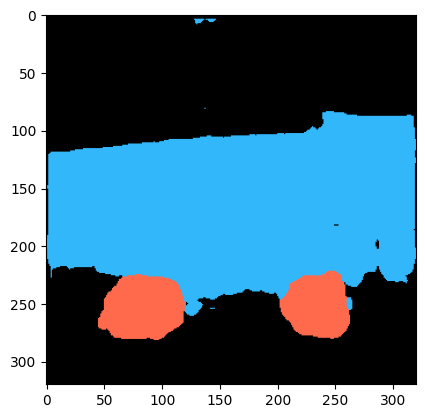

In [32]:
image_path = '/content/drive/MyDrive/DeepLearning_Dataset/DL_Images/76th.png'
image = Image.open(image_path).convert("RGB")
image = np.transpose(image ,(2,0,1)).astype(np.float32)
original_image = torchvision.transforms.Resize((320, 320))(torch.Tensor(image))
image = original_image/255.0 # normalizing original image tensor [0,1] range
logits_mask = model(image.to(DEVICE).unsqueeze(0)) 

# Compute predicted mask probabilities using softmax
predicted_mask_prob = torch.softmax(logits_mask, dim=1)  

# Get predicted mask by selecting the class with highest probability
max_values, predicted_mask = torch.max(predicted_mask_prob, dim=1)
plt.imshow(mask_to_class_rgb(predicted_mask))  


## Gradio code

In [34]:
import gradio as gr
# Define your function that performs image segmentation
def perform_deployment(image):
  
    image = np.transpose(image ,(2,0,1)).astype(np.float32)
    original_image = torchvision.transforms.Resize((320, 320))(torch.Tensor(image))
    image = original_image/255.0 # normalizing original image tensor [0,1] range
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) 

    # Compute predicted mask probabilities using softmax
    predicted_mask_prob = torch.softmax(logits_mask, dim=1)  

    # Get predicted mask by selecting the class with highest probability
    max_values, predicted_mask = torch.max(predicted_mask_prob, dim=1)
    plt.imshow(mask_to_class_rgb(predicted_mask))
    plt.axis('off')
    plt.tight_layout()
    # Convert the Matplotlib plot to a NumPy array
    fig = plt.gcf()
    fig.canvas.draw()
    Label_image = np.array(fig.canvas.renderer._renderer)
    plt.close()
    # Return the segmented image as a NumPy array
    Label_image = Image.fromarray(Label_image)

# Return the segmented image as a PIL image object
    return Label_image 

# Define the Gradio interface
input_image = gr.inputs.Image(label="Input Image")
Label_image = gr.outputs.Image(type='pil',label="Annotated Image")

# Define the Gradio app
app = gr.Interface(fn=perform_deployment, inputs=input_image, outputs=Label_image)

# Launch the app
app.launch()




/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>